# Tree-Based Models for a Regression Problem, and Hyperparameter Tuning

We will work on Review dataset to see how Tree-based regressors (Decision Tree, Random Forest), along with efficient optimization techniques (GridSearch, RandomizedSearch), perform to predict the log_votes field of our review dataset.

    Reading the dataset
    Exploratory data analysis and missing value imputation
    Stop word removal and stemming
    Scaling numerical fields
    Splitting the training dataset into training and validation
    Computing Bag of Words features
    Fitting tree-based regressors and checking the validation performance
    
Overall dataset schema:

    reviewText: Text of the review
    summary: Summary of the review
    verified: Whether the purchase was verified (True or False)
    time: UNIX timestamp for the review
    rating: Rating of the review
    log_votes: Logarithm-adjusted votes log(1+votes)



# 1. Reading the dataset

We will use the pandas library to read our dataset.

In [2]:
import pandas as pd
url = 'https://github.com/aws-samples/aws-machine-learning-embark-nlp/raw/master/DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv'
#df = pd.read_csv(url,index_col=0,parse_dates=[0])
df = pd.read_csv(url,parse_dates=[0])

In [5]:
df.head(10)

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.000000
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.000000
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.000000
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.000000
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.000000
5,"I've never used a Rosetta product before, but ...",Excellent Product,True,1350000000,5.0,1.791759
6,Acronis comes through for me when Windows back...,Acronis Just Great!,True,1394841600,5.0,0.000000
7,on the life-cycle of this item & the other vis...,still over 3 yrs. left..,True,1394841600,5.0,0.000000
8,Piece of S---. Just wanted a staic non-video ...,sucks,True,1427068800,1.0,0.000000
9,So far it has been very nice and easy to use.,Love AVG,True,1420156800,4.0,0.000000


In [6]:
df.describe()

,time,rating,log_votes
count,5.500000e+04,55000.000000,55000.000000
mean,1.369527e+09,3.568018,0.529112
std,1.150230e+08,1.626900,0.960084
min,9.427104e+08,1.000000,0.000000
25%,1.322676e+09,2.000000,0.000000
50%,1.405382e+09,4.000000,0.000000
75%,1.448064e+09,5.000000,1.098612
max,1.537142e+09,5.000000,7.799753


# 2. Exploratory data analysis and missing values imputation

Let's look at the range and distribution of log_votes

In [7]:
df["log_votes"].min()

0.0

In [8]:
df["log_votes"].max()

7.799753318287247

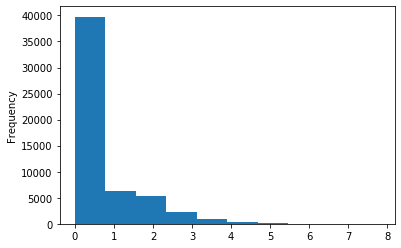

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [10]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


Let's fill-in the missing values for reviewText below. We will just use the placeholder "Missing" here.

In [11]:
df["reviewText"].fillna("Missing", inplace=True)

# 3. Stop word removal and stemming

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solharsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).


In [13]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

stop = stopwords.words('english')

In [14]:
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [15]:
stop_words = [word for word in stop if word not in excluding]

In [16]:
snow = SnowballStemmer('english')

In [17]:
def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
        final_text_list.append(final_string)
    return final_text_list

In [18]:
print("Pre-processing the reviewText field")
df["reviewText"] = process_text(df["reviewText"].tolist()) 

Pre-processing the reviewText field


# 4. Scaling numerical fields:
We will apply min-max scaling to our rating field so that they will be between 0-1.

In [19]:
df["rating"] = (df["rating"] - df["rating"].min())/(df["rating"].max()-df["rating"].min())
df["time"] = (df["time"] - df["time"].min())/(df["time"].max()-df["time"].min())

# 5. Splitting the training dataset into training and validation
Sklearn library has a useful function to split datasets. We will use the train_test_split() function. In the example below, we get 90% of the data for training and 10% is left for validation.

In [20]:
from sklearn.model_selection import train_test_split 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "rating", "time"]],
                                                  df["log_votes"].tolist(),
                                                  test_size=0.10,
                                                  shuffle=True
                                                 )

# 6. Computing Bag of Words Features

We are using binary features here. TF and TF-IDF are other options.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(binary=True,
                                   max_features=50 # Limit the vocabulary size
                                  )
# Fit and transform
X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist())
# Only transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())

In [22]:
print(tfidf_vectorizer.vocabulary_)

{'not': 23, 'softwar': 33, 'get': 11, 'back': 1, 'realli': 30, 'find': 10, 'need': 21, 'help': 14, 'well': 45, 'mani': 19, 'great': 13, 'problem': 26, 'download': 6, 'version': 42, 'still': 34, 'good': 12, 'one': 24, 'instal': 15, 'window': 46, 'work': 47, 'way': 44, 'use': 39, 'product': 27, 'comput': 4, 'support': 35, 'recommend': 31, 'like': 16, 'want': 43, 'program': 28, 'user': 40, 'year': 49, 'much': 20, 'could': 5, 'would': 48, 'file': 9, 'easi': 7, 'even': 8, 'make': 18, 'also': 0, 'look': 17, 'better': 2, 'time': 36, 'new': 22, 'upgrad': 38, 'tri': 37, 've': 41, 'run': 32, 'buy': 3, 'price': 25, 'purchas': 29}


Let's merge our features to train a model.

In [23]:
import numpy as np
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values))
X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values,
                                  X_val["time"].values))

# 7. Fitting tree-based regressors and checking the validation performance

### DecisionTreeRegressor

Let's first fit a DecisionTreeRegressor from Sklearn library, and check the performance on the validation dataset.

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
dtRegressor = DecisionTreeRegressor(max_depth = 10,
                                    min_samples_leaf = 15)
dtRegressor.fit(X_train_features, y_train)
dtRegressor_val_predictions = dtRegressor.predict(X_val_features)
print("DecisionTreeRegressor on Validation: Mean_squared_error: %f, R_square_score: %f" % \
      (mean_squared_error(y_val, dtRegressor_val_predictions), r2_score(y_val, dtRegressor_val_predictions)))

DecisionTreeRegressor on Validation: Mean_squared_error: 0.671350, R_square_score: 0.301933


### RandomForestRegressor

Let's now fit a RandomForestRegressor from Sklearn library, and check the performance on the validation dataset.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
rfRegressor = RandomForestRegressor(n_estimators = 200,
                                    max_depth = 10,
                                    min_samples_leaf = 15)
rfRegressor.fit(X_train_features, y_train)
rfRegressor_val_predictions =rfRegressor.predict(X_val_features)
print("RandomForestRegressor on Validation: Mean_squared_error: %f, R_square_score: %f" % \
      (mean_squared_error(y_val, rfRegressor_val_predictions), r2_score(y_val, rfRegressor_val_predictions)))

RandomForestRegressor on Validation: Mean_squared_error: 0.601390, R_square_score: 0.374678


# Hyperparameter Tuning

Let's try different parameter values and see how the DecisionTreeRegressor model performs under some combinations of parameters.

### GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
 
dt = DecisionTreeRegressor()
parameters = {'max_depth': [10, 20, 30, 40],
              'min_samples_leaf': [5, 15, 25, 35]}
                     
# NOTE: GridSearchCV uses by default the score function of the estimator to evaluate 
# (r2_score for regression; accuracy_score for classification). If desired, 
# other scoring functions can be specified via the 'scoring' parameter. 

regressor_grid = GridSearchCV(dt,
                              parameters,
                              cv=5,
                              verbose=1,
                              #n_jobs=-1,
                              scoring = 'neg_mean_squared_error')
regressor_grid.fit(X_train_features, y_train)
print("Best parameters: ", regressor_grid.best_params_)
print("Best score: ", regressor_grid.best_score_)
regressor_grid_val_predictions = regressor_grid.best_estimator_.predict(X_val_features)
print("DecisionTreeRegressor with GridSearchCV on Validation: Mean_squared_error: %f, R_square_score: %f" % \
      (mean_squared_error(y_val, regressor_grid_val_predictions), r2_score(y_val, regressor_grid_val_predictions)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   52.4s finished


Best parameters:  {'max_depth': 10, 'min_samples_leaf': 35}
Best score:  -0.6259033641867322
DecisionTreeRegressor with GridSearchCV on Validation: Mean_squared_error: 0.650712, R_square_score: 0.323393


### RandomizedSearchCV

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
dt = DecisionTreeRegressor()
parameters = {'max_depth': [10, 20, 30, 40],
              'min_samples_leaf': [5, 15, 25, 35]}
# NOTE: RandomizedSearchCV uses by default the score function of the estimator to evaluate
# (r2_score for regression; accuracy_score for classification). 
# If desired, other scoring functions can be specified via the 'scoring' parameter.
# NOTE: You can also experiment with different n_iter 
# (number of parameter settings that are sampled by the RandomizedSearch), default = 10
regressor_rand = RandomizedSearchCV(dt,
                                    parameters,
                                    cv=5,
                                    verbose=1,
                                    #n_jobs=-1,
                                    scoring = 'neg_mean_squared_error')
regressor_rand.fit(X_train_features, y_train)
print("Best parameters: ", regressor_rand.best_params_)
print("Best score: ", regressor_rand.best_score_)
regressor_rand_val_predictions = regressor_rand.best_estimator_.predict(X_val_features)
print("DecisionTreeRegressor with RandomizedSearchCV on Validation: Mean_squared_error: %f, R_square_score: %f" % \
      (mean_squared_error(y_val, regressor_rand_val_predictions), r2_score(y_val, regressor_rand_val_predictions)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   24.3s finished


Best parameters:  {'min_samples_leaf': 35, 'max_depth': 10}
Best score:  -0.6259033641867322
DecisionTreeRegressor with RandomizedSearchCV on Validation: Mean_squared_error: 0.650712, R_square_score: 0.323393


Hyperparameter Tuning: Always a good idea to try other parameter ranges and/or combinations of parameters. If training time is a priority, we can try RandomizedSearchCV instead of GridSearchCV, it's much faster and with almost as good results.